In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn

In [2]:
pd. set_option("display.max_columns", None) 

In [3]:
df = pd.read_csv('./ios-fitness-and-medical-cleaned-data.csv')

#### Feature Engineering

In [4]:
def is_english_supported(language):
    return language.find('English') >=0

In [5]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [6]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

In [7]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [8]:
def create_price_category(rating_count):
    if (rating_count >0.0 and rating_count<1.0):
        return '0+'
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    return None

In [9]:
def is_app_available_in_multiple_languages(languages):
    return len(languages.split(',')) > 1

In [10]:
def is_privacy_data_collected(privacy_data):
    if pd.notna(privacy_data):
        return True
    return False

In [11]:
def is_app_ever_updated(version_count):
    return version_count > 1

In [12]:
def is_app_updated_in_2022(last_updated_date, released_date, versions_count):
    if (versions_count < 2):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [13]:
def perform_feature_engineering(df):
    lang_na_indexes = df[df['Languages'].isna()].index
    df.loc[lang_na_indexes, 'Languages'] = 'Not Specified'
    df['is_english_supported'] = df['Languages'].apply(is_english_supported)
    df['Service Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
    df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['is_available_in_multiple_langs'] = df['Languages'].apply(is_app_available_in_multiple_languages)
    df['is_privacy_data_collected'] = df['Privacy Data'].apply(is_privacy_data_collected)
    df['is_app_ever_updated'] = df['Number of Versions'].apply(is_app_ever_updated)
    df['Price Category'] = df['Price'].apply(create_price_category)
    for index in df.index:
        last_updated_date = df.at[index, 'Last Version Date']
        released_date = df.at[index, 'First Version Date']
        version = df.at[index, 'Number of Versions']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)

In [14]:
perform_feature_engineering(df)

In [15]:
df[:5]

,Unnamed: 0,App Name,Size,Age Rating,Languages,Price,InApp Purchase,Average Rating,Rating Count,Privacy Data,App Link,Number of Versions,Last Version Date,First Version Date,App Type,is_english_supported,Service Type,App Grade,Rating Count Range,is_available_in_multiple_langs,is_privacy_data_collected,is_app_ever_updated,Price Category,is_updated_this_year
0,0,H and W Drug Store,21.5 MB,12+,"English, Spanish",0.00,False,4.0,4,NaN,https://apps.apple.com/us/app/h-and-w-drug-sto...,1,NaN,NaN,MEDICAL,True,FREE,VERY GOOD,1+,True,False,False,None,False
1,1,H&P-card™,10.1 MB,17+,"English, Spanish",2.99,False,1.0,1,NaN,https://apps.apple.com/us/app/h-p-card/id56971...,5,"Sep 28, 2020","Oct 20, 2012",MEDICAL,True,PAID,BAD,1+,True,False,True,1+,False
2,2,H-Book – osobní zdravotní záznamy,47.1 MB,12+,"English, Czech",0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-book-osobn%C3%...,21,"Jun 28, 2017","Jun 5, 2013",MEDICAL,True,FREE,BAD,0,True,False,True,None,False
3,3,H-FACT,4.1 MB,12+,English,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-fact/id1568969345,5,"Nov 24, 2021","Jul 5, 2021",MEDICAL,True,FREE,BAD,0,False,False,True,None,False
4,4,H-Module,27.6 MB,17+,Not Specified,0.00,False,0.0,0,NaN,https://apps.apple.com/us/app/h-module/id15728...,2,"Jun 26, 2021","Jun 22, 2021",MEDICAL,False,FREE,BAD,0,False,False,True,None,False


#### VISUALIZATION

In [16]:
rating_count_range_order = ['0', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+', '5,000,000+', '10,000,000+', '50,000,000+']

In [17]:
price_range_order = ['0+', '1+', '5+', '10+', '50+', '100+', '500+']

In [18]:
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

In [19]:
df['Rating Count Range'].value_counts()

0             56349
1+            25975
10+            9355
5+             7362
100+           3250
50+            2206
1,000+         1267
500+            848
10,000+         501
5,000+          361
50,000+         130
100,000+        129
500,000+         23
1,000,000+        6
Name: Rating Count Range, dtype: int64

In [20]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

In [21]:
def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

In [22]:
def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

#### Price influence on the mobile application?

In [23]:
df['Price'].value_counts()

0.00      99590
0.99       1816
1.99       1443
2.99       1150
4.99        879
          ...  
239.99        1
499.99        1
45.99         1
119.99        1
46.99         1
Name: Price, Length: 80, dtype: int64

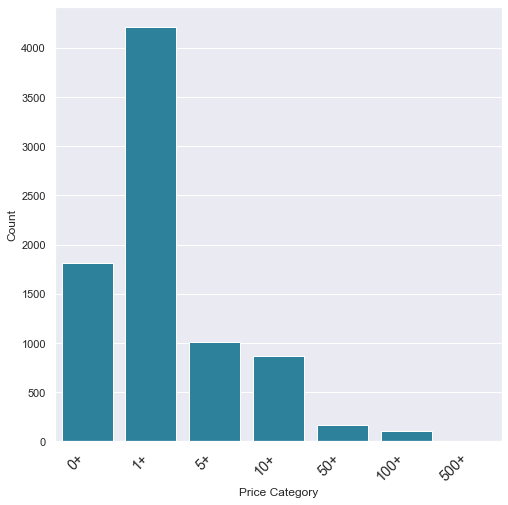

In [24]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

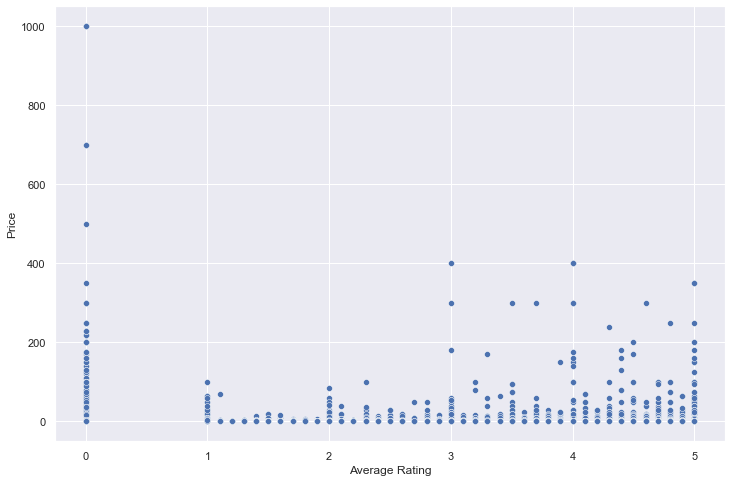

In [25]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

In [26]:
df['Price Category'].value_counts()

1+      4207
0+      1816
5+      1010
10+      868
50+      164
100+     103
500+       4
Name: Price Category, dtype: int64

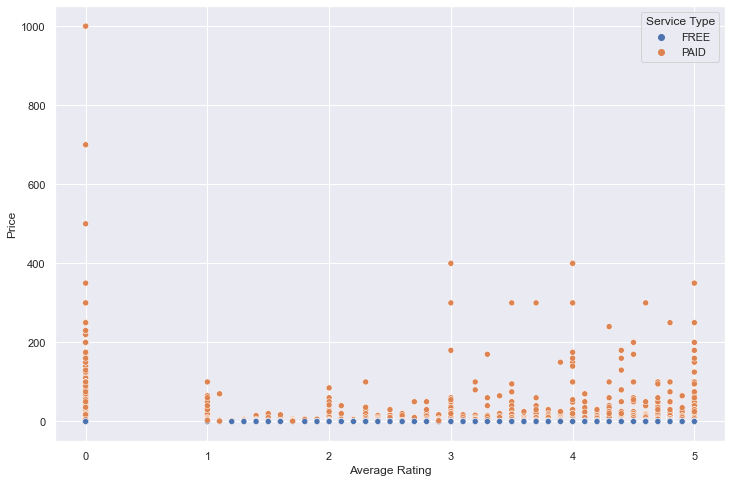

In [27]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Service Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

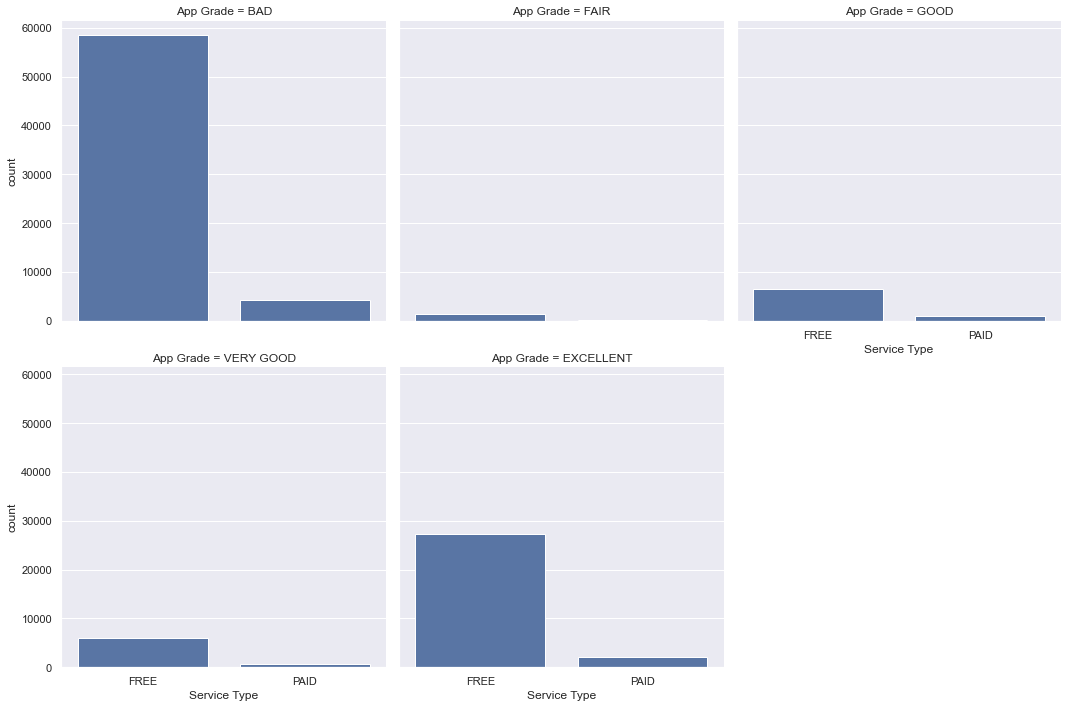

In [28]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Service Type", order=['FREE', 'PAID'])

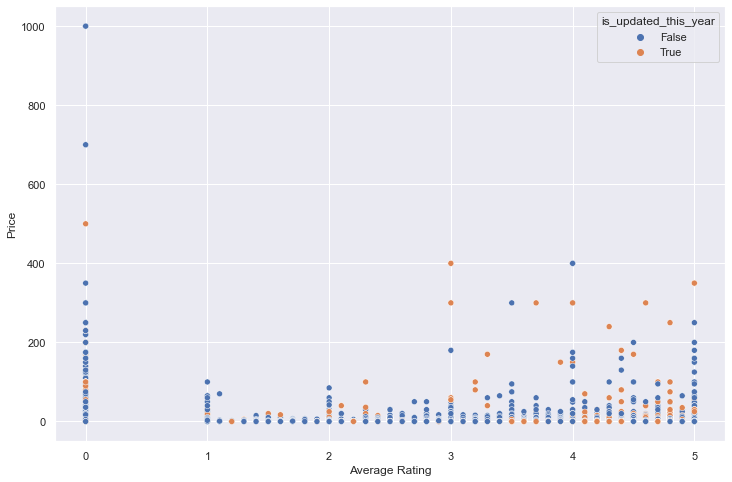

In [29]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

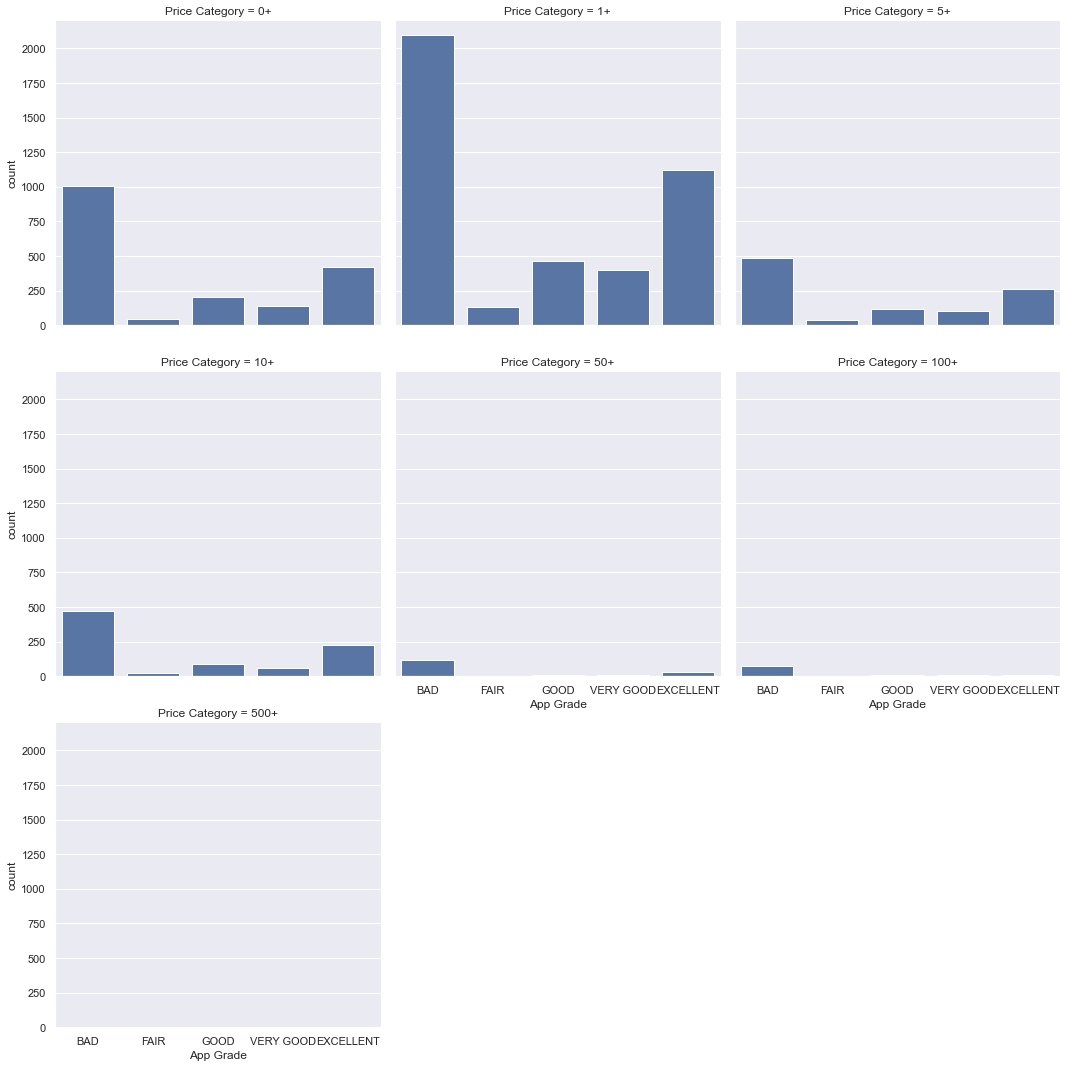

In [30]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=3, height=5, aspect=1.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "App Grade", order=app_grade_order)

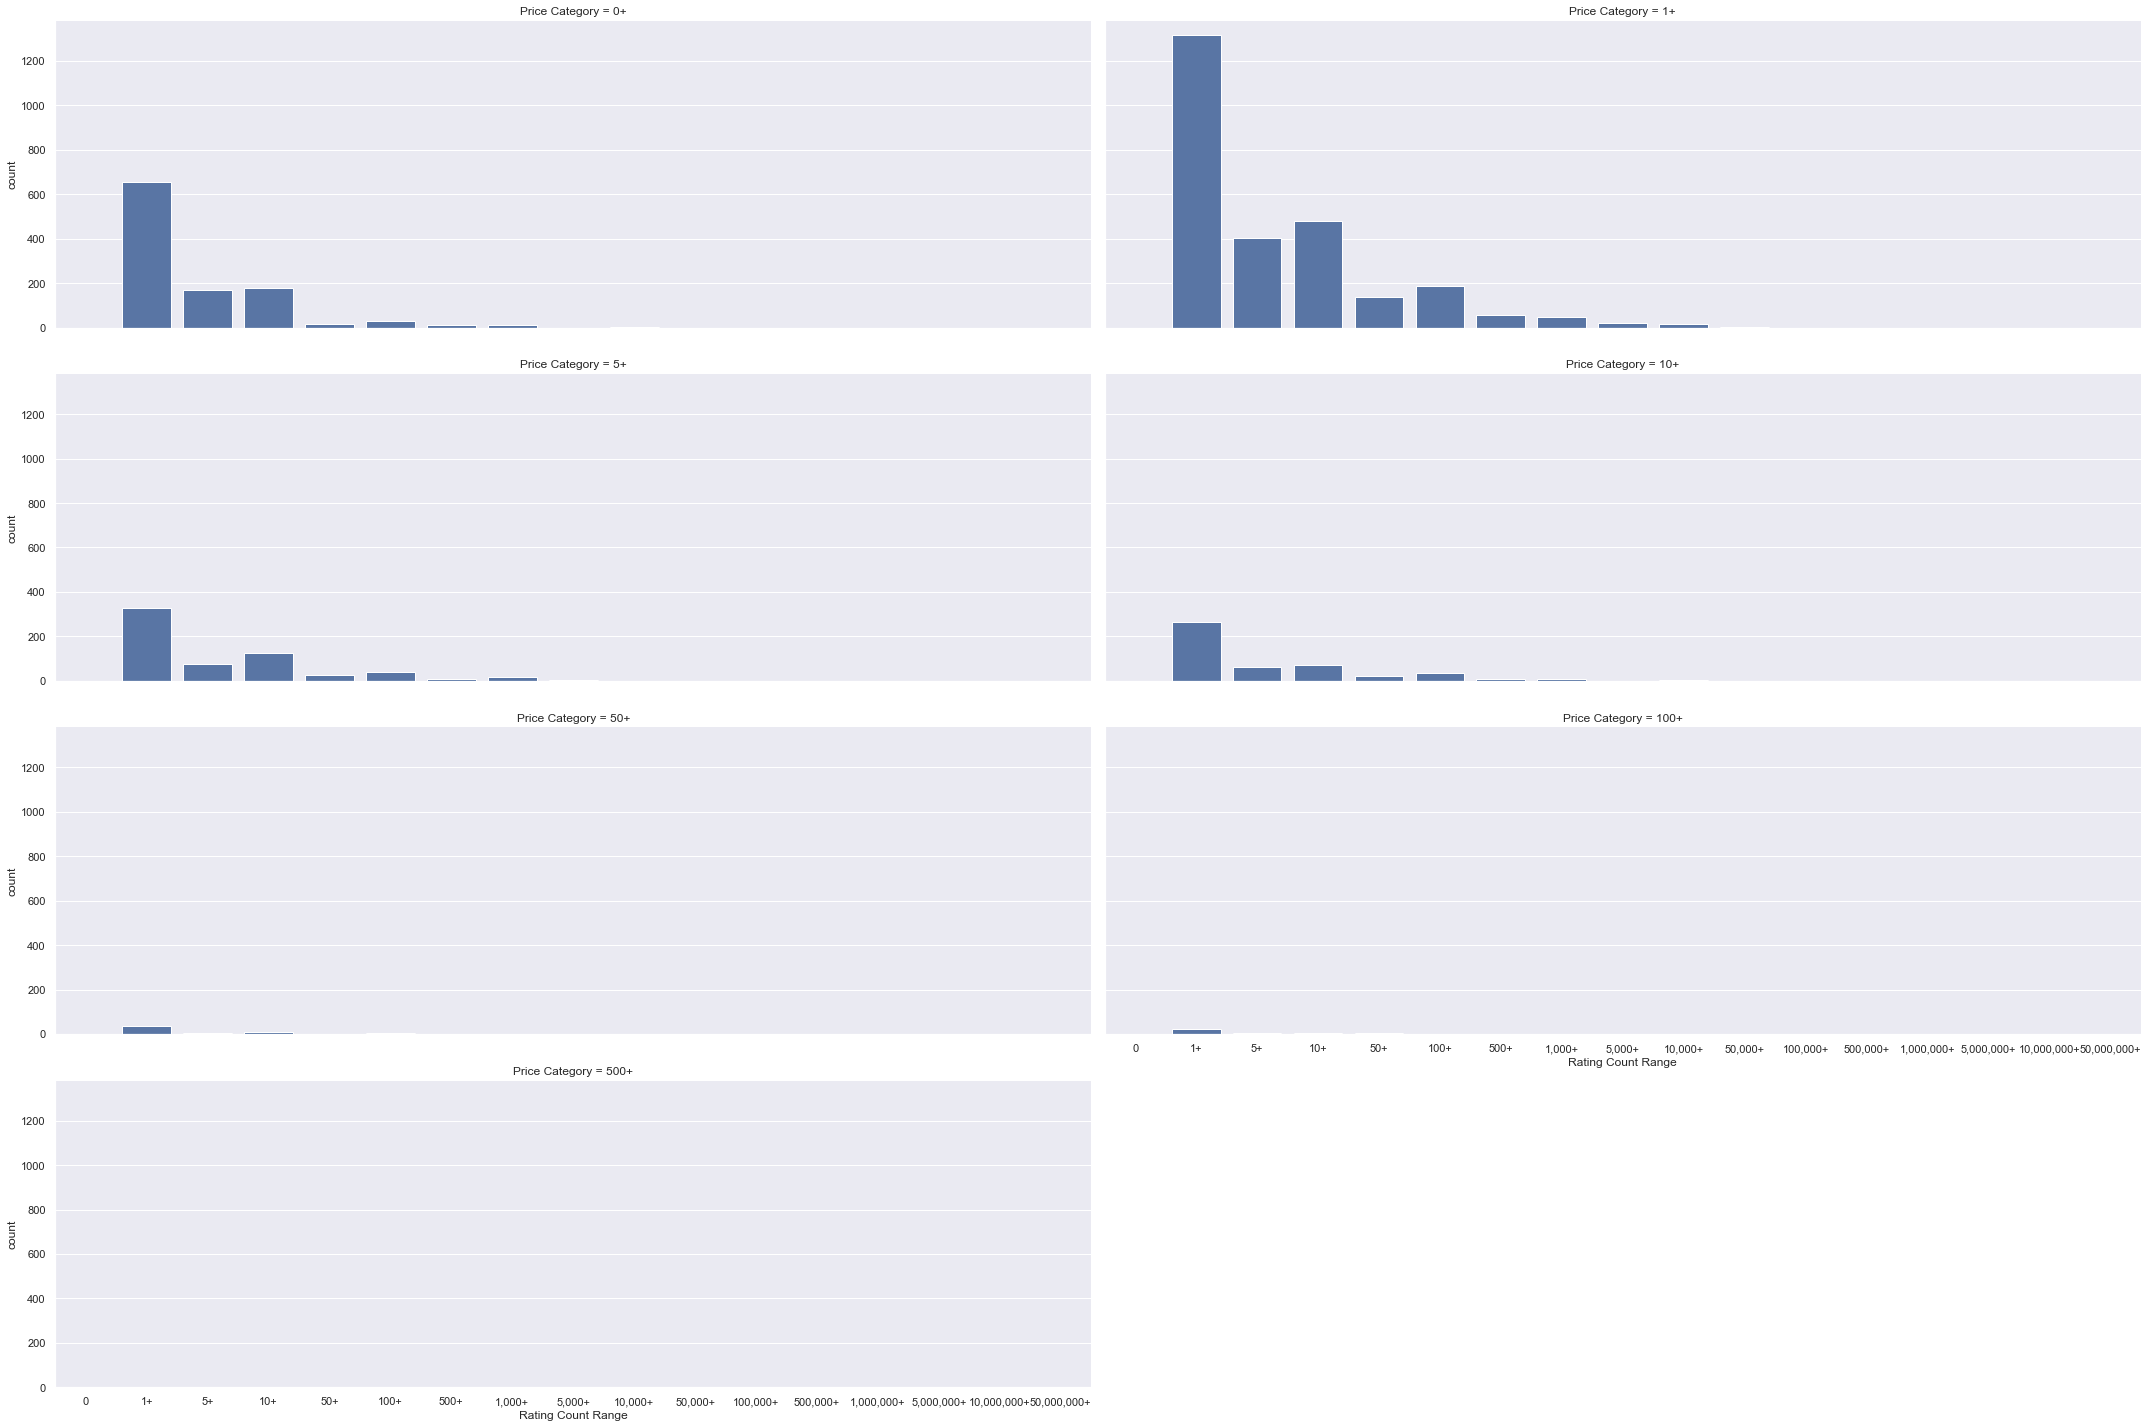

In [31]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Price Category", col_wrap=2, height=5, aspect=3.0,
                                        col_order=price_range_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


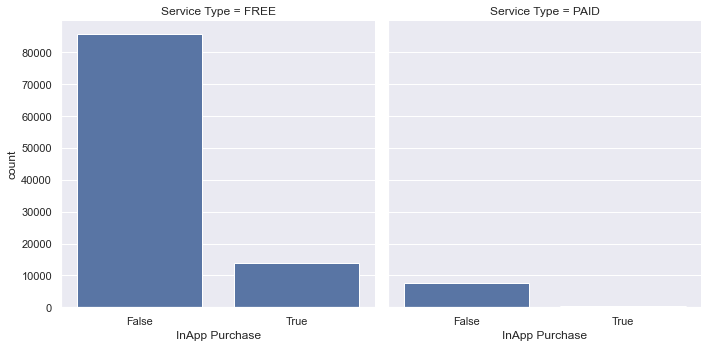

In [32]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Service Type", col_wrap=2, height=5, aspect=1.0)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

#### Application Rating effect on the app?

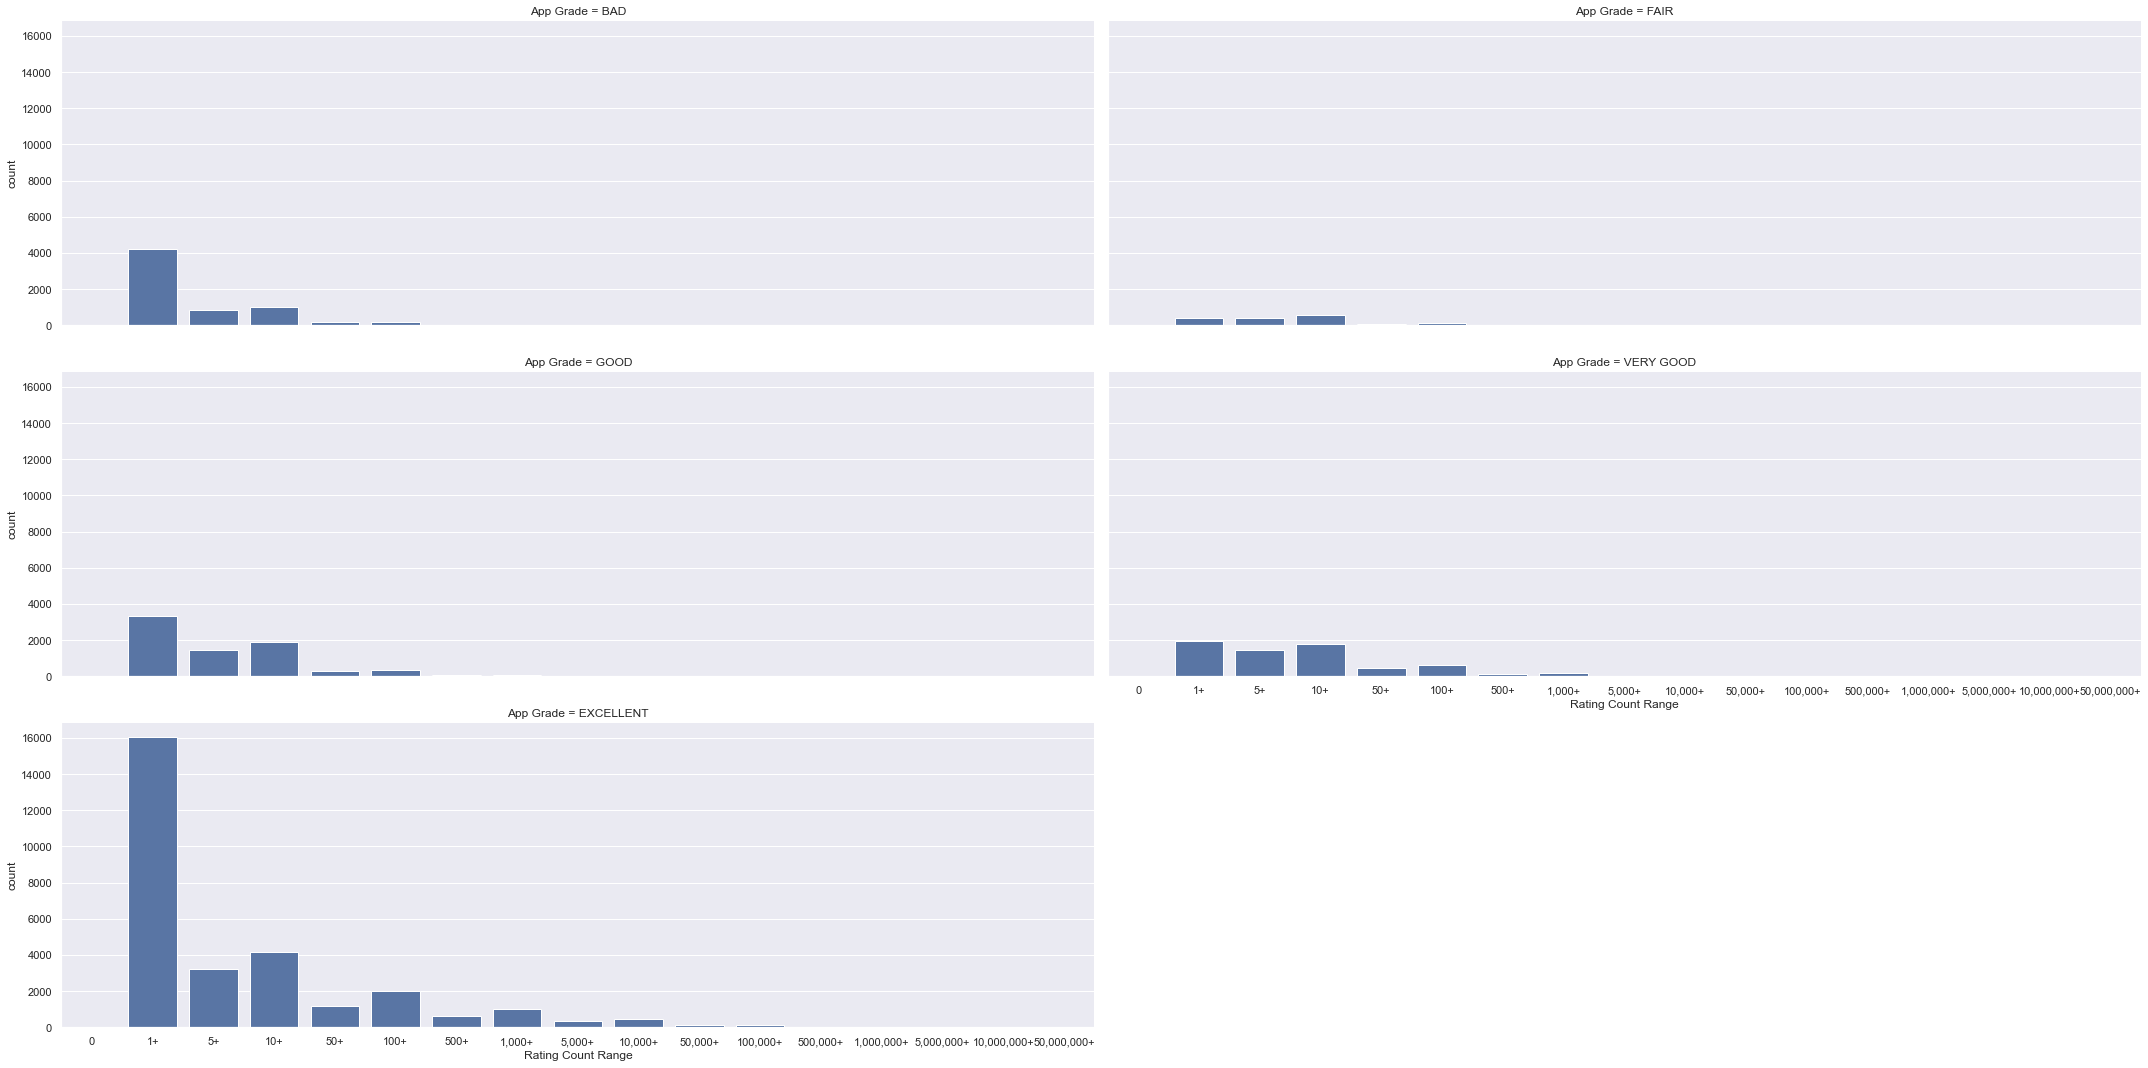

In [33]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

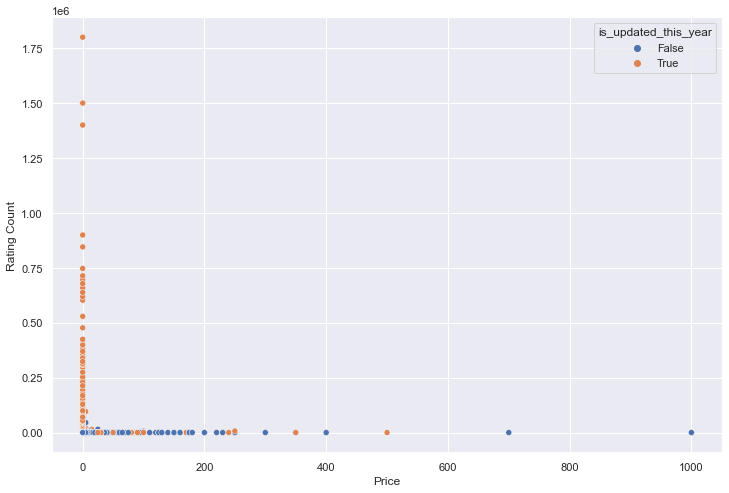

In [34]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

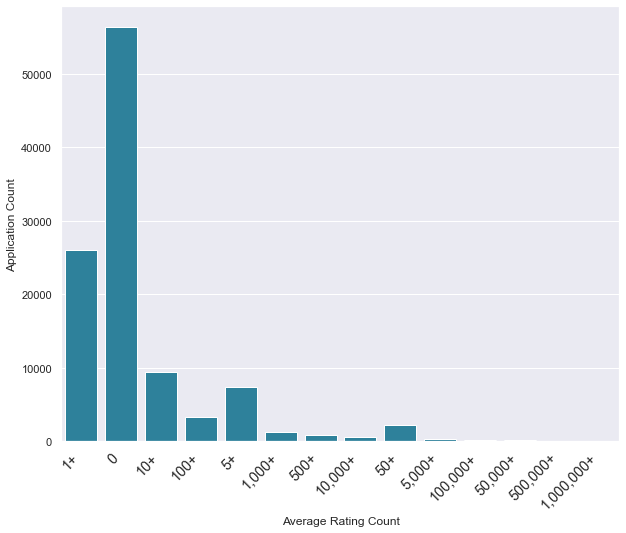

In [35]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

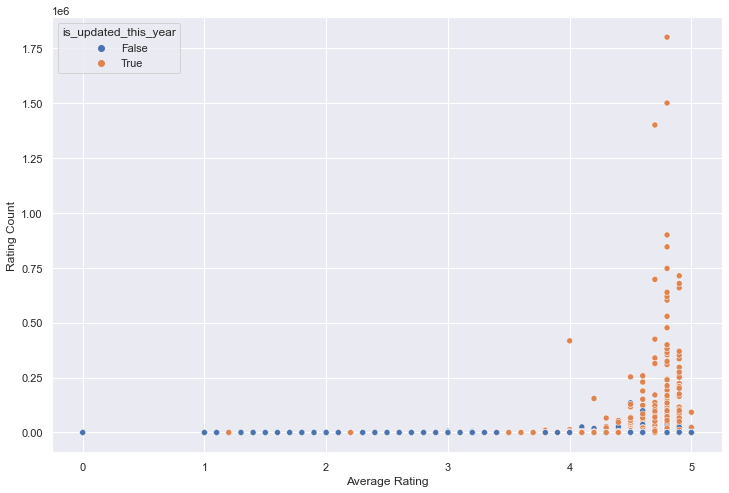

In [36]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

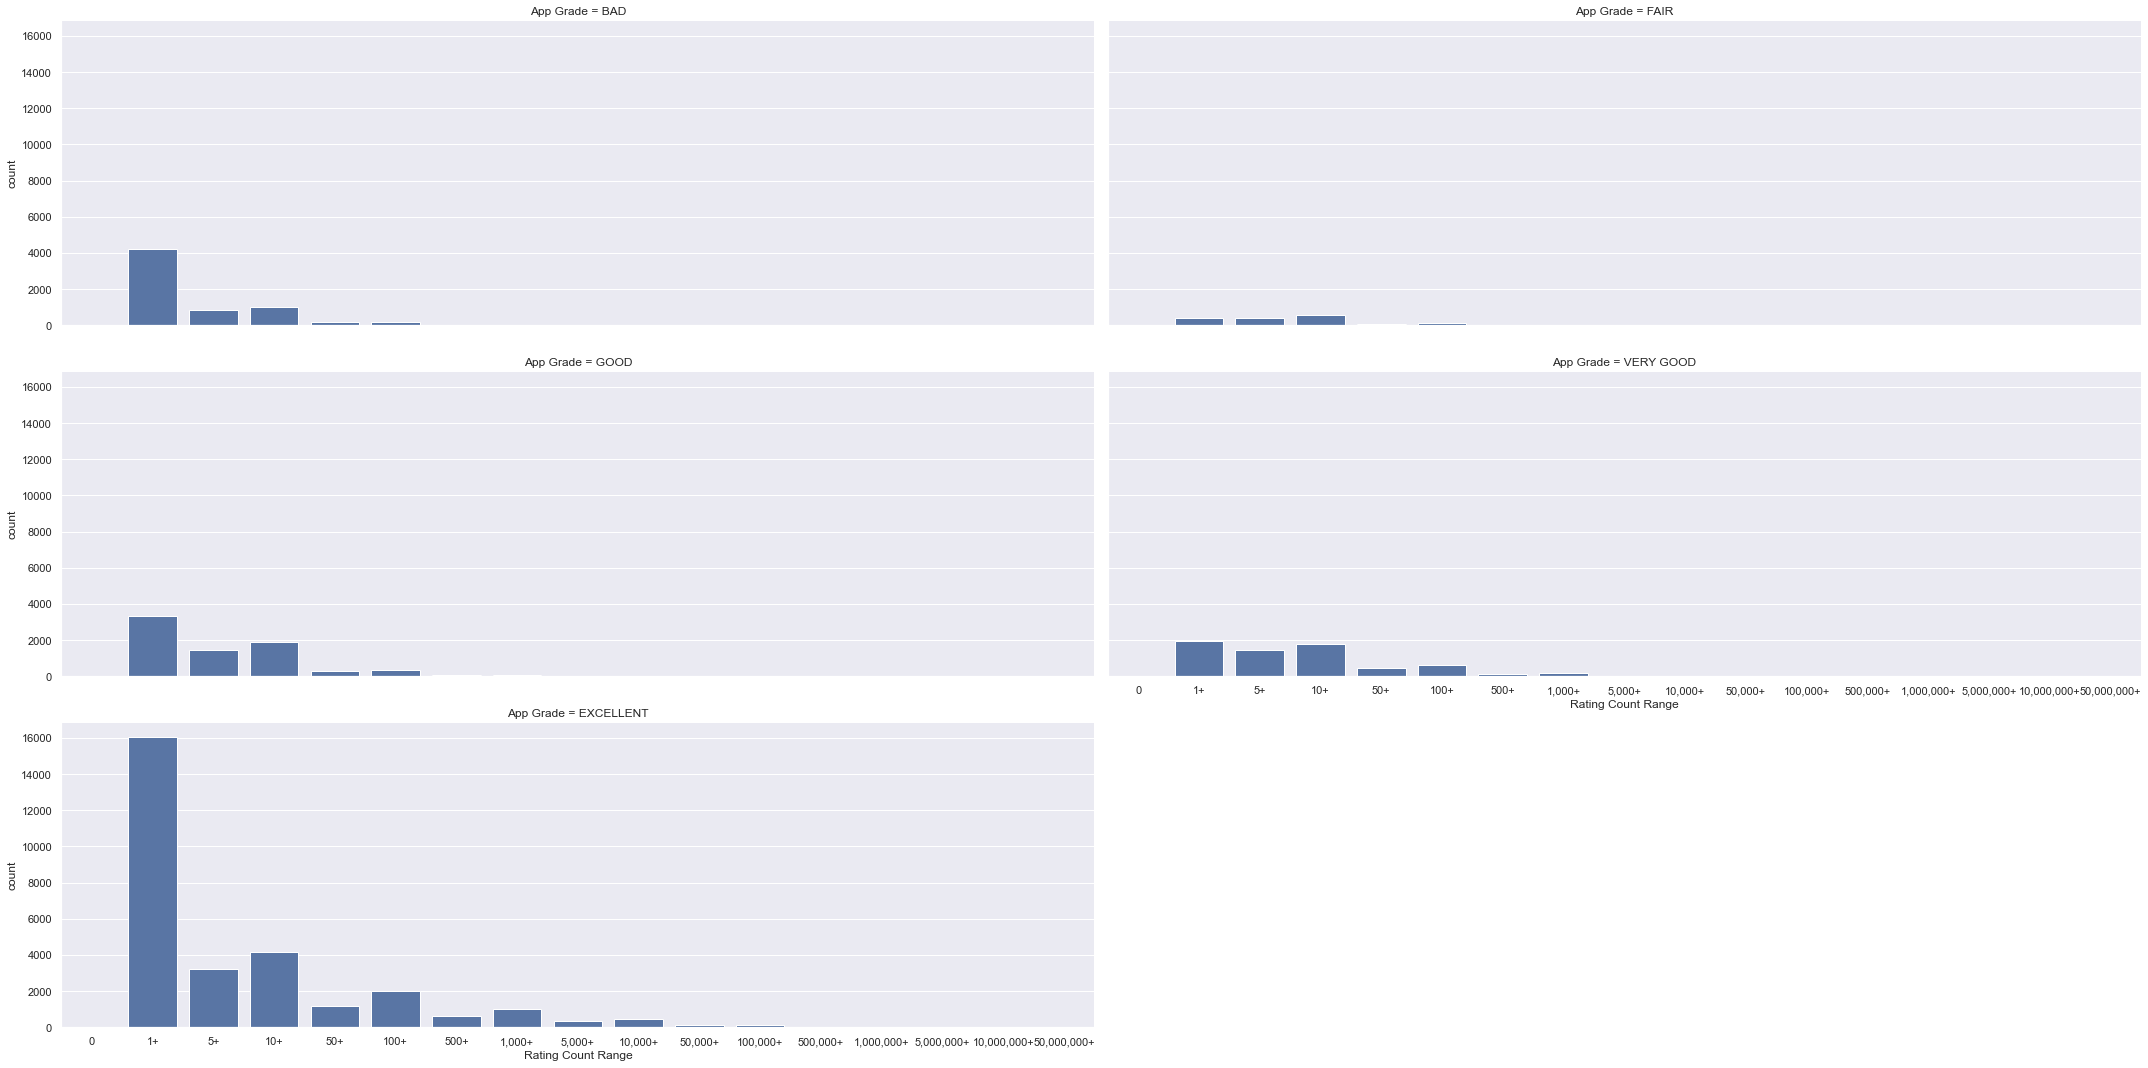

In [37]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=2, height=5, aspect=3.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

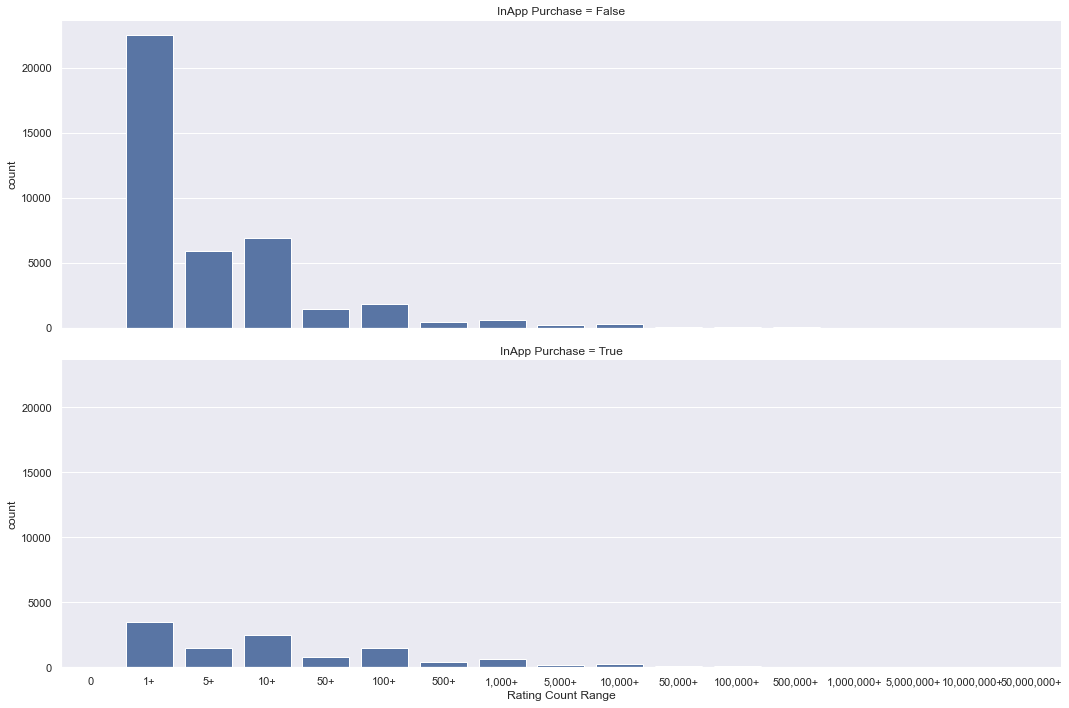

In [38]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="InApp Purchase", col_wrap=1, height=5, aspect=3.0)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

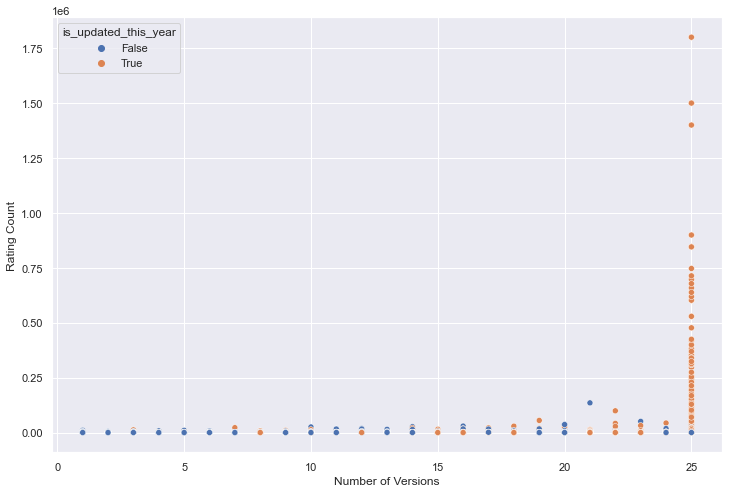

In [39]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_updated_this_year',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

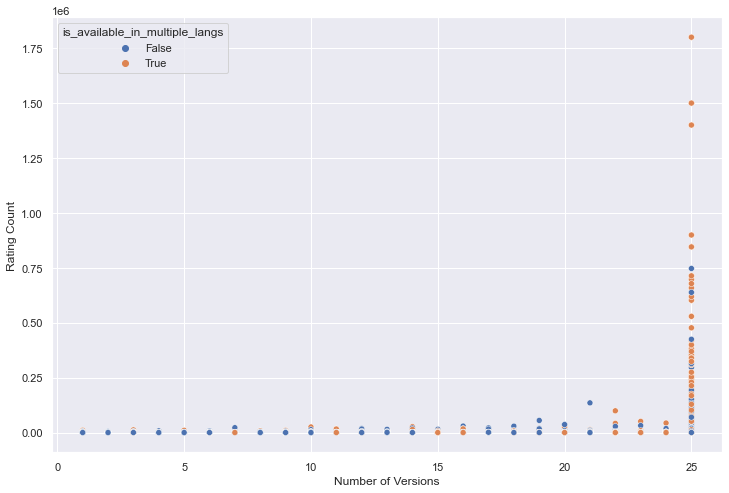

In [40]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_available_in_multiple_langs',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

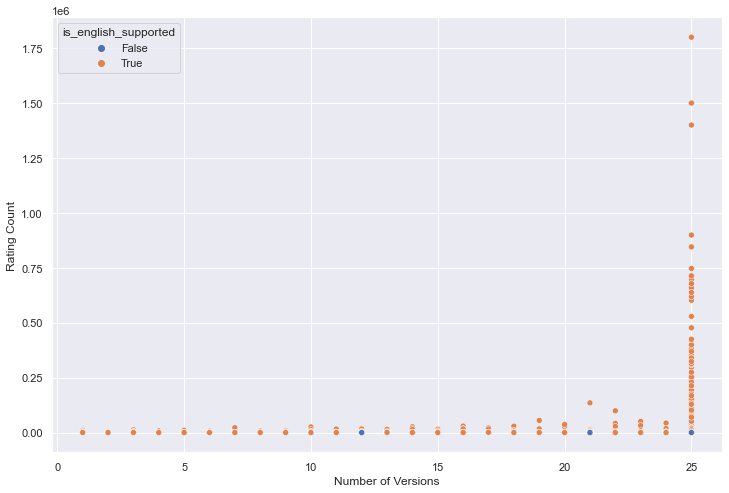

In [41]:
sbn.scatterplot(data=df, y='Rating Count', x='Number of Versions', hue='is_english_supported',
                legend='brief', color="#0a4020", palette="deep")
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

#### Application Type 

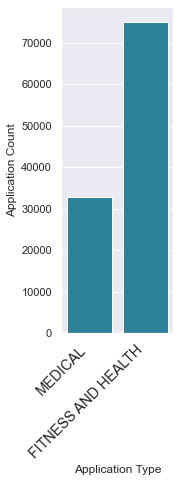

In [42]:
draw_count_plot(df, 'App Type', 'Application Type', 'Application Count', fig_size=(2,6))

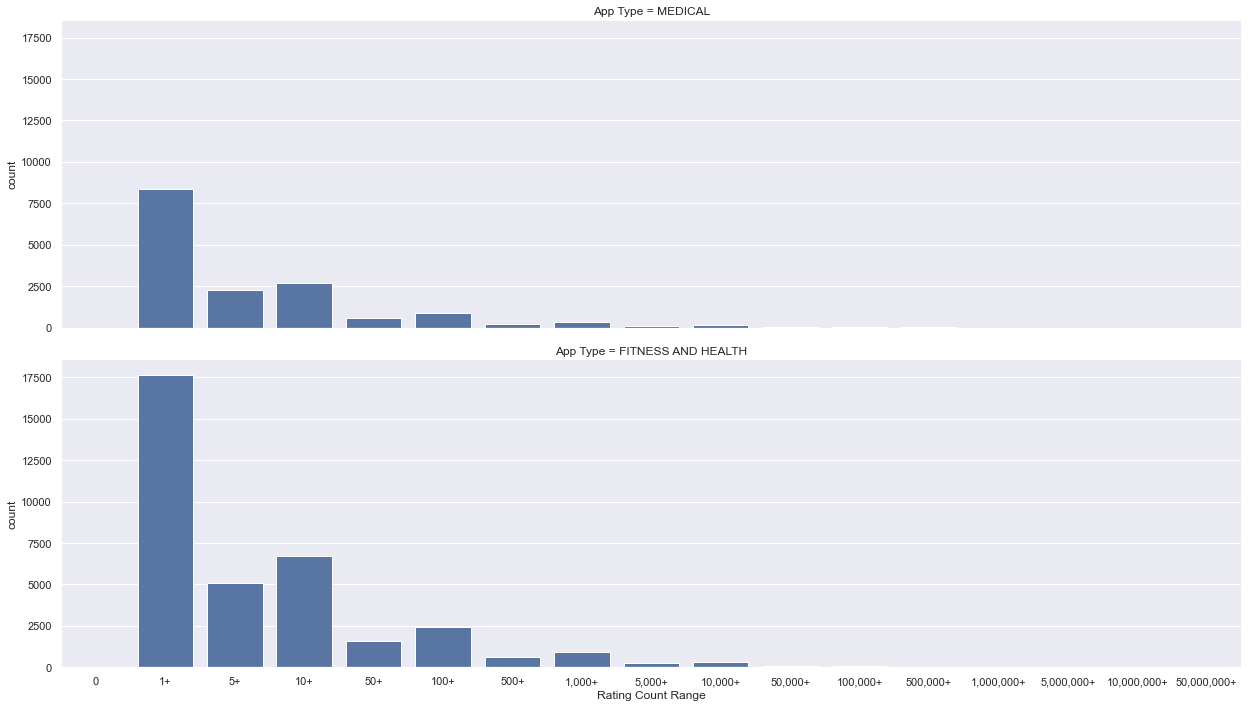

In [43]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=1, height=5, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

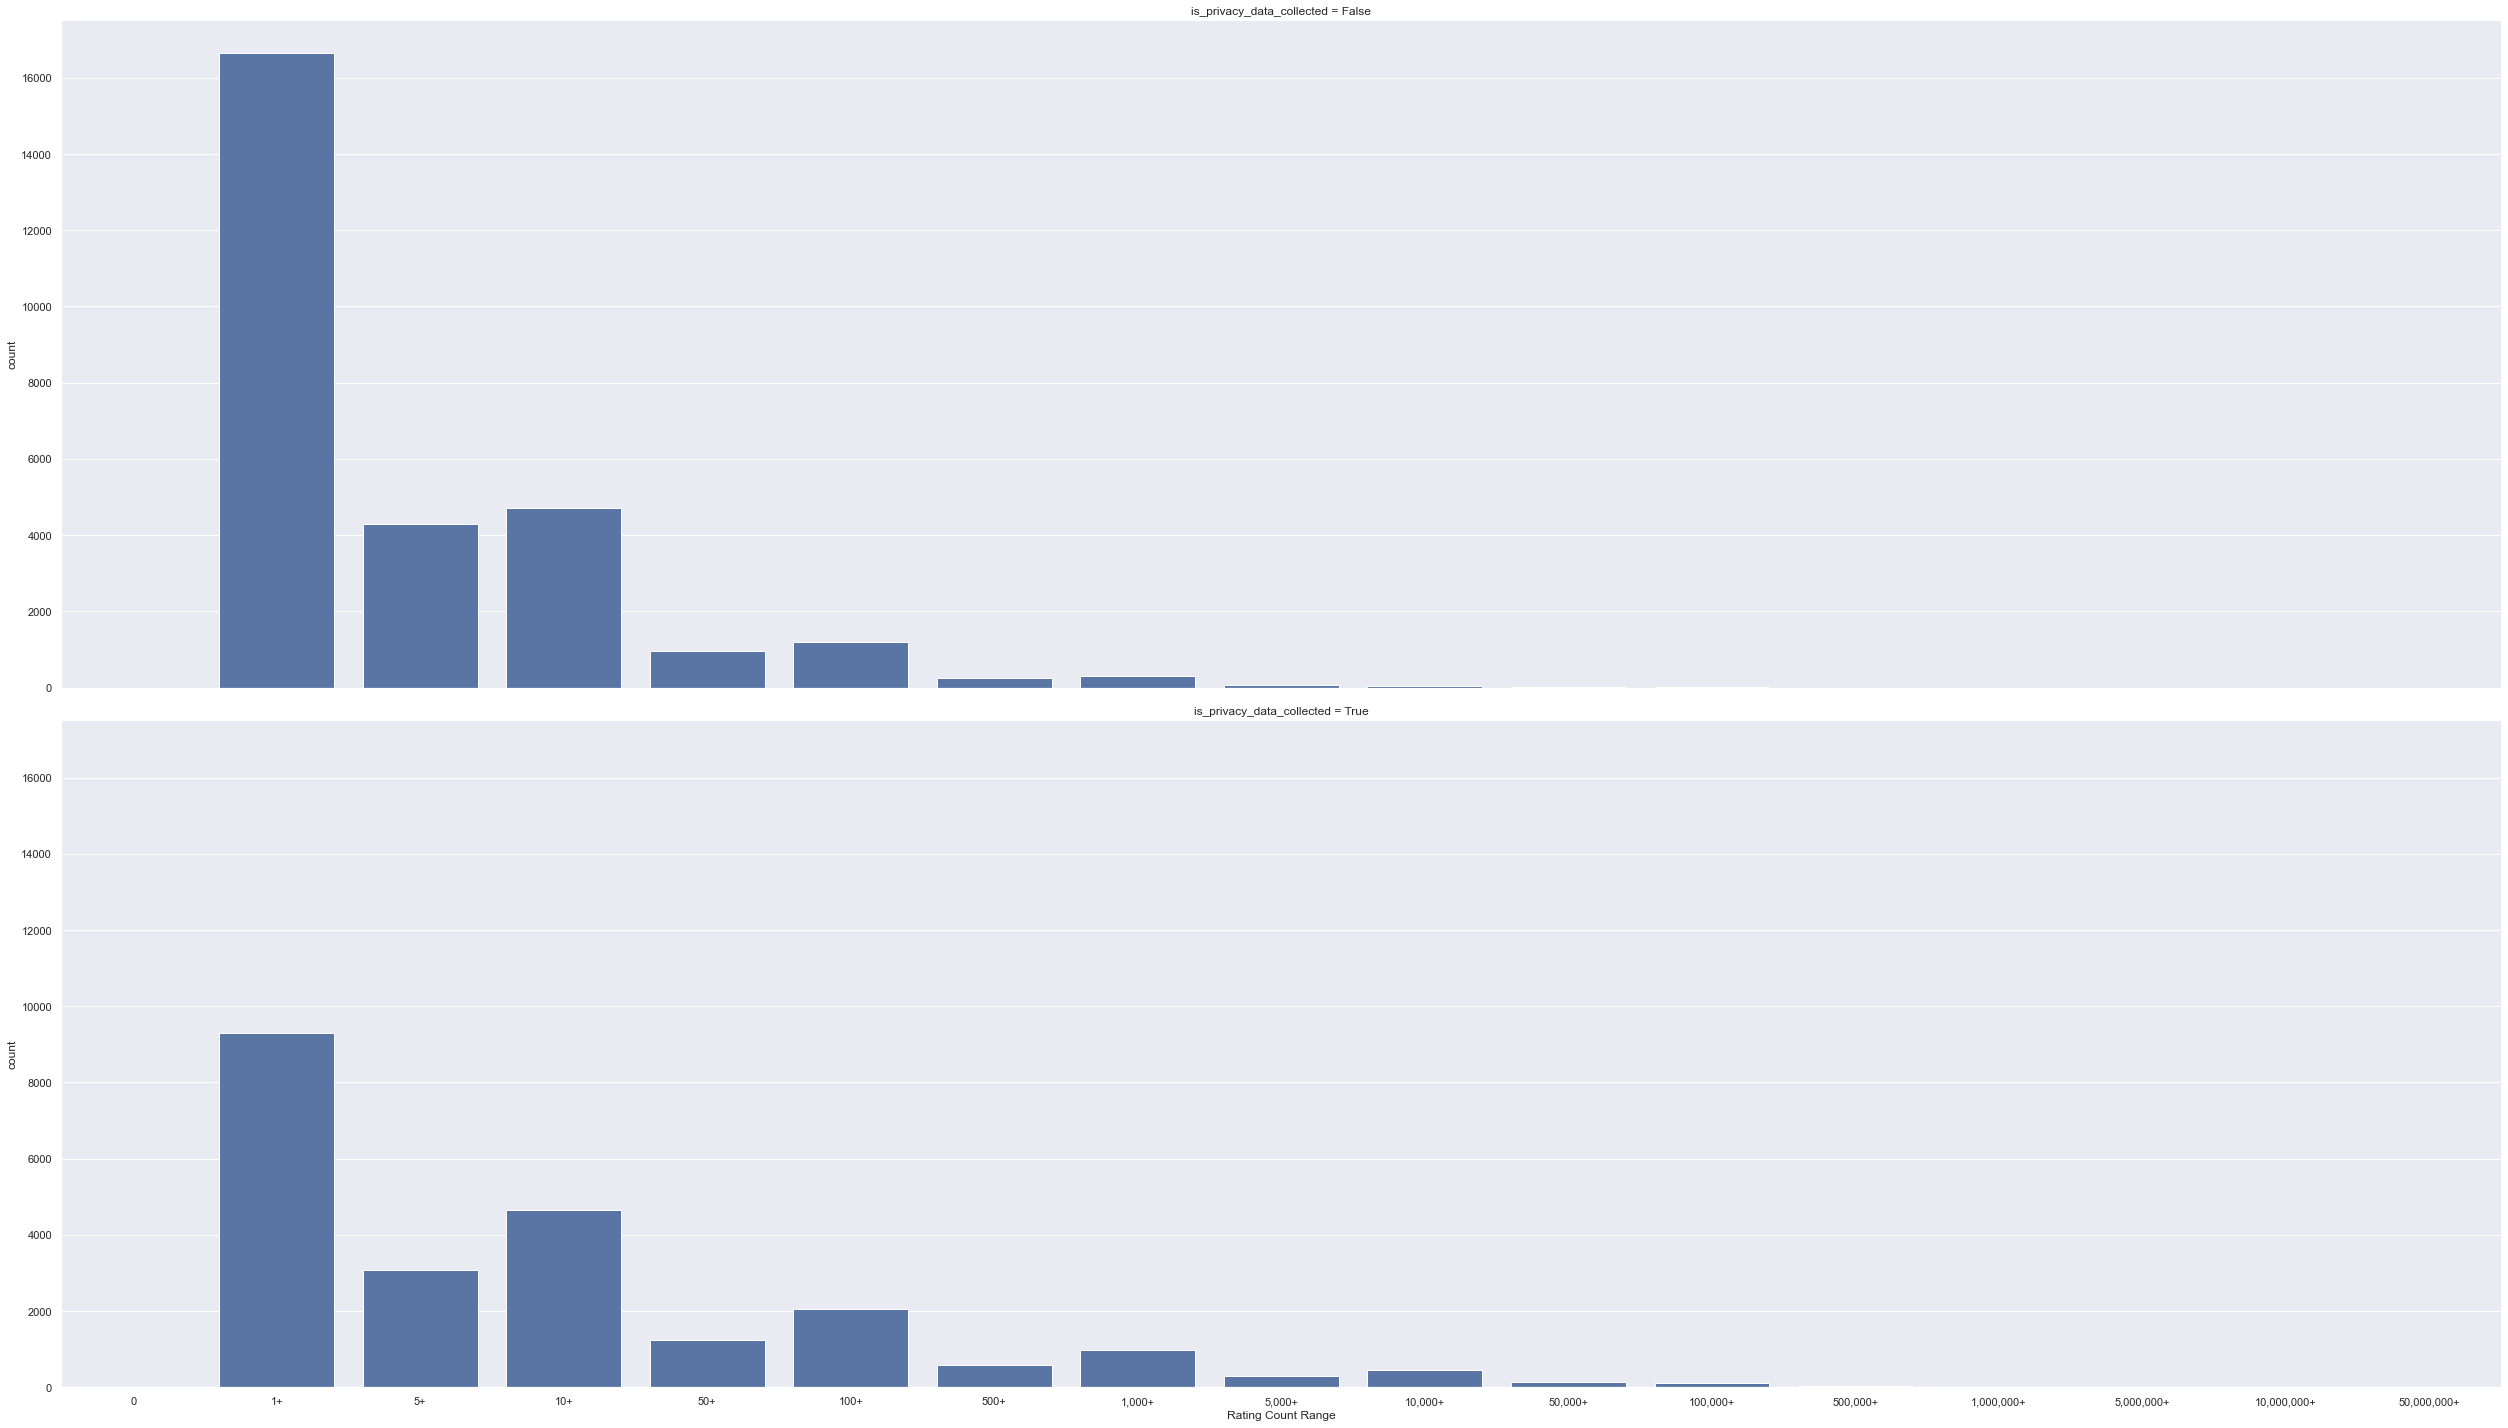

In [44]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="is_privacy_data_collected", col_wrap=1, height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

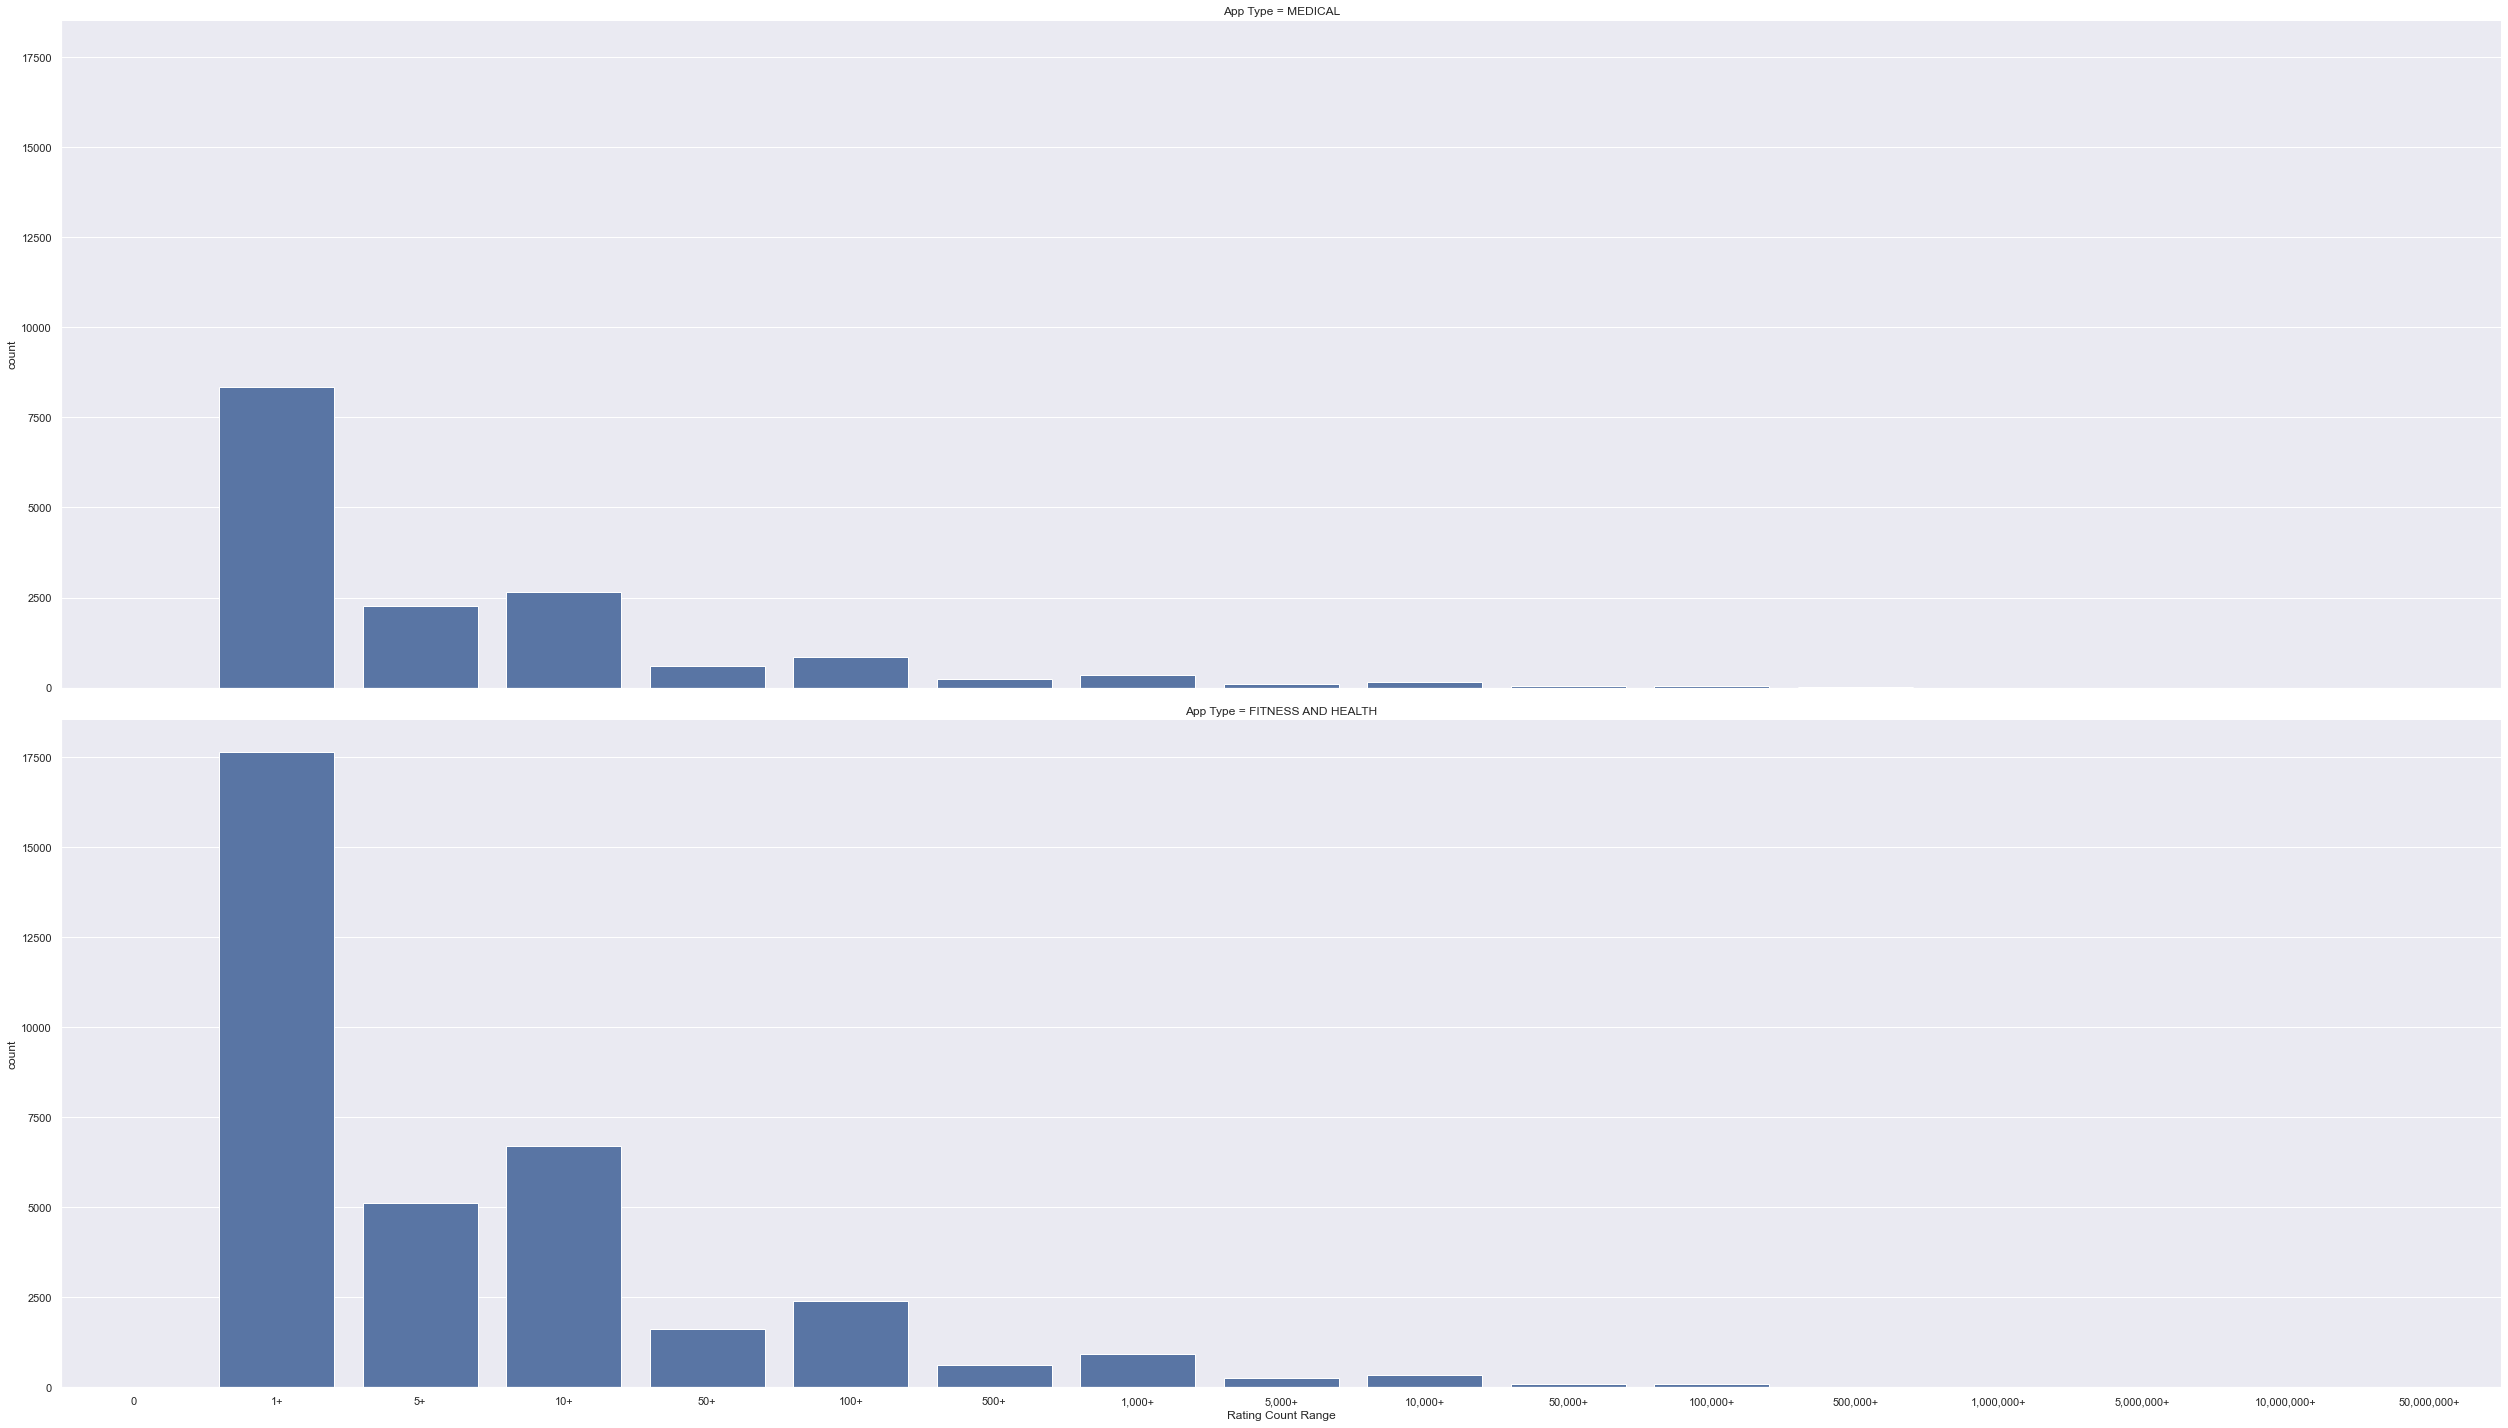

In [45]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type" ,col_wrap=1, 
                                        height=10, aspect=3.5)
eng_supp_app_grade_plot.map(sbn.countplot, "Rating Count Range", order=rating_count_range_order)

In [46]:
df['is_privacy_data_collected'].value_counts()

False    63766
True     43996
Name: is_privacy_data_collected, dtype: int64

<AxesSubplot:xlabel='Average Rating', ylabel='Price'>

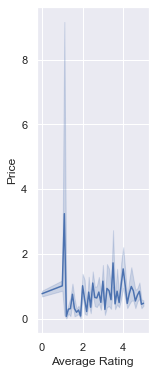

In [48]:
sbn.lineplot(data=df, x='Average Rating', y='Price')